In [1]:
import os,sys
sys.path.append('../')
import camb
import hmvec as hm
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import erf

OSError: libifport.so.5: cannot open shared object file: No such file or directory

In [3]:
path = "/global/homes/c/cpopik"

https://arxiv.org/pdf/2202.12911.pdf

# Writing Custom HODs

In [4]:
logMs = np.linspace(11.5, 15, 200)

In [5]:
# These are specific HOD functions whose powers spectrum we're going to fit to

def Nc_LRG(logM, params):
    f_ic, logM_cut, sigma = [params.get(key) for key in ['f_ic', 'logM_cut', 'sigma']]
    return (f_ic / 2) * (1- erf((logM_cut - logM)/(np.sqrt(2)*sigma)))

def Ns_LRG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa * M_cut) / M_1)**alpha * Nc

LRG_paper_params = {
    'logM_cut': np.array([12.7]*len(logMs)),
    'logM_1': np.array([13.6]*len(logMs)),
    'sigma': 0.2,
    'alpha': 1.15,
    'kappa': 0.08,
    'f_ic': 0.8
}

In [6]:
def Nc_ELG(logM, params):
    p_max, Q, logM_cut, sigma_M, gamma, logM_1, alpha, kappa = \
        [params.get(key) for key in ['p_max', 'Q', 'logM_cut', 'sigma_M', 'gamma', 'logM_1', 'alpha', 'kappa']]
    
    phi = (1/(np.sqrt(2*np.pi)*sigma_M)) * np.exp(-(1/2)*((logM-logM_cut)/sigma_M)**2)
    
    big_phi = (1/2) * (1 + erf((gamma*(logM-logM_cut))/(np.sqrt(2)*sigma_M)))  # for trevor
    
    A = p_max - 1/Q
    
    return 2*A*phi*big_phi+(1/(2*Q))*(1 + erf((logM-logM_cut)/0.01))
    
def Ns_ELG(logM, Nc, params):
    kappa, logM_cut, logM_1, alpha = \
        [params.get(key) for key in ['kappa', 'logM_cut', 'logM_1', 'alpha']]
    M, M_cut, M_1 = 10**logM, 10**logM_cut, 10**logM_1
    return ((M - kappa*M_cut) / M_1) ** alpha


ELG_paper_params = {
    'p_max': 0.075,
    'Q': 95,
    'logM_cut': np.array([11.9]*len(logMs)),
    'sigma_M': 0.5,
    'gamma': 5,
    'logM_1': np.array([14.2]*len(logMs)),
    'alpha': 0.65,
    'kappa': 1.35
}

/tmp/ipykernel_63663/2443139875.py:10: RuntimeWarning: invalid value encountered in power
  return ((M - kappa * M_cut) / M_1)**alpha * Nc
/tmp/ipykernel_63663/4078506053.py:17: RuntimeWarning: invalid value encountered in power
  return ((M - kappa*M_cut) / M_1) ** alpha


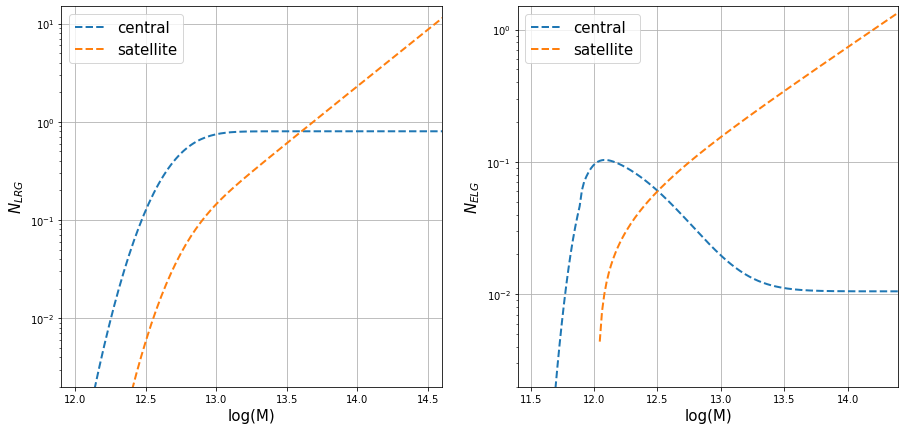

In [7]:
fig, (ax1, ax2)  = plt.subplots(1, 2, figsize=(15, 7))

ax1.grid(True)
ax1.set_yscale('log')
ax1.set_xlim(11.9, 14.6)
ax1.set_ylim(2e-3, 15)
ax1.set_xlabel('log(M)', fontsize=15)
ax1.set_ylabel('$N_{LRG}$', fontsize=15)

# logMs = np.linspace(12, 14.5, 200)
Nc_LRGplot = Nc_LRG(logMs, LRG_paper_params)
Ns_LRGplot = Ns_LRG(logMs, Nc_LRGplot, LRG_paper_params)

ax1.plot(logMs, Nc_LRGplot, label='central', ls='--', lw=2)
ax1.plot(logMs, Ns_LRGplot, label='satellite', ls='--', lw=2)
ax1.legend(fontsize=15)


ax2.grid(True)
ax2.set_yscale('log')
ax2.set_xlabel('log(M)', fontsize=15)
ax2.set_ylabel('$N_{ELG}$', fontsize=15)

# logMs = np.linspace(11.5, 14, 200)
Nc_ELGplot = Nc_ELG(logMs, ELG_paper_params)
Ns_ELGplot = Ns_ELG(logMs, Nc_ELGplot, ELG_paper_params)

ax2.plot(logMs, Nc_ELGplot, label='central', ls='--', lw=2)
ax2.plot(logMs, Ns_ELGplot, label='satellite', ls='--', lw=2)
ax2.legend(fontsize=15)
ax2.set_ylim(2e-3, 1.5)
ax2.set_xlim(11.4, 14.4)


plt.show()

# hmvec process

In [8]:
# Create model
ms = np.geomspace(10**12.5,10**max(logMs),200)
zs = np.linspace(0.2,3.,20)
ks = np.geomspace(1e-4,100,1001)
hcos = hm.HaloModel(zs,ks,ms=ms)

In [9]:
# To add a HOD as described in the hmvec documentation:
mthresh = 10**10.5+zs*0.
hcos.add_hod(name="g",mthresh=mthresh, ignore_existing=True)

# Then to retrieve the profiles for that HOD
hcos._get_hod('g').shape

(20, 200, 1001)

In [39]:
galaxytype='LRG'

if galaxytype=='LRG':
    Ns_model, Nc_model, model_params = Ns_LRG, Nc_LRG, LRG_paper_params
elif galaxytype=='ELG':
    Ns_model, Nc_model, model_params = Ns_ELG, Nc_ELG, ELG_paper_params

hcos.add_custom_hod(name="g2",mthresh=mthresh, ignore_existing=True, 
                    Nc_model=Nc_model, Ns_model=Ns_model, 
                    model_params=model_params, z_dep=False)

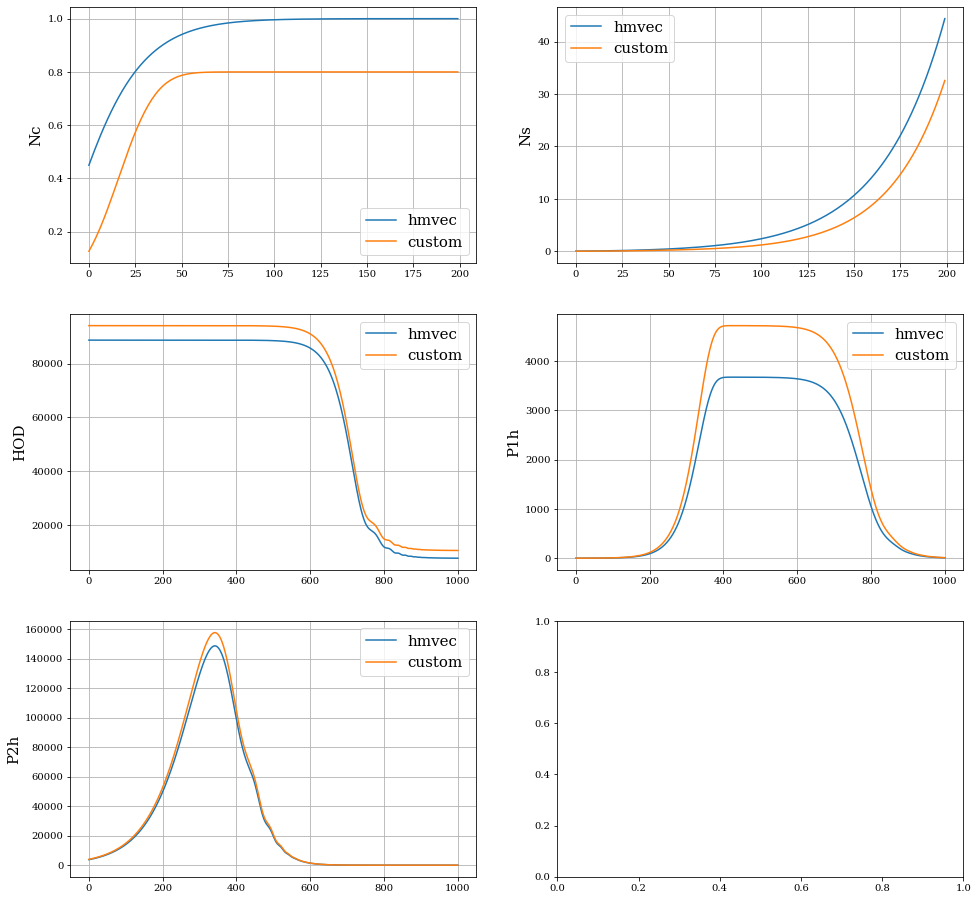

In [40]:
fig, ((ax1, ax2), (ax3, ax4), (ax5, ax6))  = plt.subplots(3, 2, figsize=(16, 16))


i, j = 15, 150
ax1.grid(True)
ax1.set_ylabel('Nc', fontsize=15)
ax1.plot(hcos.hods['g']['Nc'][i], label='hmvec')
ax1.plot(hcos.hods['g2']['Nc'][i], label='custom')
ax1.legend(fontsize=15)

ax2.grid(True)
ax2.set_ylabel('Ns', fontsize=15)
ax2.plot(hcos.hods['g']['Ns'][i], label='hmvec')
ax2.plot(hcos.hods['g2']['Ns'][i], label='custom')
ax2.legend(fontsize=15)

ax3.grid(True)
ax3.set_ylabel('HOD', fontsize=15)
ax3.plot(hcos._get_hod('g')[i, j], label='hmvec')
ax3.plot(hcos._get_hod('g2')[i, j], label='custom')
ax3.legend(fontsize=15)

ax4.grid(True)
ax4.set_ylabel('P1h', fontsize=15)
ax4.plot(hcos.get_power_1halo('g')[i], label='hmvec')
ax4.plot(hcos.get_power_1halo('g2')[i], label='custom')
ax4.legend(fontsize=15)

ax5.grid(True)
ax5.set_ylabel('P2h', fontsize=15)
ax5.plot(hcos.get_power_2halo('g')[i], label='hmvec')
ax5.plot(hcos.get_power_2halo('g2')[i], label='custom')
ax5.legend(fontsize=15)

plt.show()

# Getting final Power spectra things

In [41]:
# TEST

gdndztest=np.array([0.        , 0.        , 0.        , 0.        , 0.22657055,
       0.88568486, 0.51493306, 1.13285273, 1.11225541, 1.21524202,
       1.15345005, 1.13285273, 1.70957775, 1.60659114, 1.62718847,
       1.73017508, 2.01853759, 1.66838311, 1.15345005, 0.53553038,
       0.35015448, 0.10298661, 0.08238929, 0.        , 0.02059732,
       0.        , 0.        , 0.02059732])

gzstest = np.linspace(0, 1.4, 29)

gdndztest2 = np.array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ,
       1.07142857, 1.14285714, 1.21428571, 1.28571429, 1.35714286,
       1.42857143, 1.5       , 1.57142857, 1.64285714, 1.71428571,
       1.78571429, 1.85714286, 1.92857143, 2.        ])

gzstest2 = np.array([0.        , 0.07142857, 0.14285714, 0.21428571, 0.28571429,
       0.35714286, 0.42857143, 0.5       , 0.57142857, 0.64285714,
       0.71428571, 0.78571429, 0.85714286, 0.92857143, 1.        ,
       1.07142857, 1.14285714, 1.21428571, 1.28571429, 1.35714286,
       1.42857143, 1.5       , 1.57142857, 1.64285714, 1.71428571,
       1.78571429, 1.85714286, 1.92857143, 2.        ])

In [13]:
hcos.add_battaglia_pres_profile("y",family='pres', xmax=20,nxs=5000, ignore_existing=True)

ells = np.linspace(0, 6000, 6001)
zmin, zmax = 0.2, 3
gzs = [0.8]

pyy_1h = hcos.get_power_1halo('y')
pyy_2h = hcos.get_power_2halo('y')
Pyy = pyy_1h + pyy_2h
yy_Cls = hcos.C_yy(ells, zs, ks, Pyy, zmin=zmin, zmax=zmax, dndz=[0.8])

pgg_1h = hcos.get_power_1halo('g')
pgg_2h = hcos.get_power_2halo('g')
Pgg = pgg_1h + pgg_2h
gg_Cls = hcos.C_gg(ells, zs, ks, Pgg, gzs=gzstest[1:], gdndz=gdndztest)

# pgk_1h = hcos.get_power_1halo('g', 'nfw')
# pgk_2h = hcos.get_power_2halo('g', 'nfw')
# Pgk = pgk_1h + pgk_2h
# gk_Cls = hcos.C_kg(ells, zs, ks, Pgk, gzs=gzs)

pgy_1h = hcos.get_power_1halo('g', 'y')
pgy_2h = hcos.get_power_2halo('g', 'y')
Pgy = pgy_1h + pgy_2h
gy_Cls = hcos.C_gy(ells, zs, ks, Pgy, gzs=gzs, zmin=zmin, zmax=zmax)

pg2g2_1h = hcos.get_power_1halo('g2')
pg2g2_2h = hcos.get_power_2halo('g2')
Pg2g2 = pg2g2_1h + pg2g2_2h
g2g2_Cls = hcos.C_gg(ells, zs, ks, Pg2g2, gzs=gzstest[1:], gdndz=gdndztest)

# pg2k_1h = hcos.get_power_1halo('g2', 'nfw')
# pg2k_2h = hcos.get_power_2halo('g2', 'nfw')
# Pg2k = pg2k_1h + pg2k_2h
# g2k_Cls = hcos.C_kg(ells, zs, ks, Pg2k, gzs=gzs)

pg2y_1h = hcos.get_power_1halo('g2', 'y')
pg2y_2h = hcos.get_power_2halo('g2', 'y')
Pg2y = pg2y_1h + pg2y_2h
g2y_Cls = hcos.C_gy(ells, zs, ks, Pg2y, gzs=gzs, zmin=zmin, zmax=zmax)

/global/u2/c/cpopik/hmvec/Notebooks/../hmvec/fft.py:90: RuntimeWarning: invalid value encountered in true_divide
  uk = ukts/kts[None,None,:]/mnorm[...,None]


Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [42]:
pyy_1h = hcos.get_power_1halo('y')
pyy_2h = hcos.get_power_2halo('y')
Pyy = pyy_1h + pyy_2h
yy_Cls = hcos.C_yy_new(ells, zs, ks, Pyy, gzstest[1:])

Check the consistency relation for tSZ
Check the consistency relation for tSZ


In [44]:
pg2y_1h = hcos.get_power_1halo('y', 'g2')
pg2y_2h = hcos.get_power_2halo('y', 'g2')
Pg2y = pg2y_1h + pg2y_2h
g2y_Cls = hcos.C_gy_new(ells, zs, ks, Pg2y, gzstest[1:], gdndz=gdndztest)

Check the consistency relation for tSZ


In [45]:
pg2g2_1h = hcos.get_power_1halo('g2')
pg2g2_2h = hcos.get_power_2halo('g2')
Pg2g2 = pg2g2_1h + pg2g2_2h
g2g2_Cls = hcos.C_gg(ells, zs, ks, Pg2g2, gzs=gzstest[1:], gdndz=gdndztest)

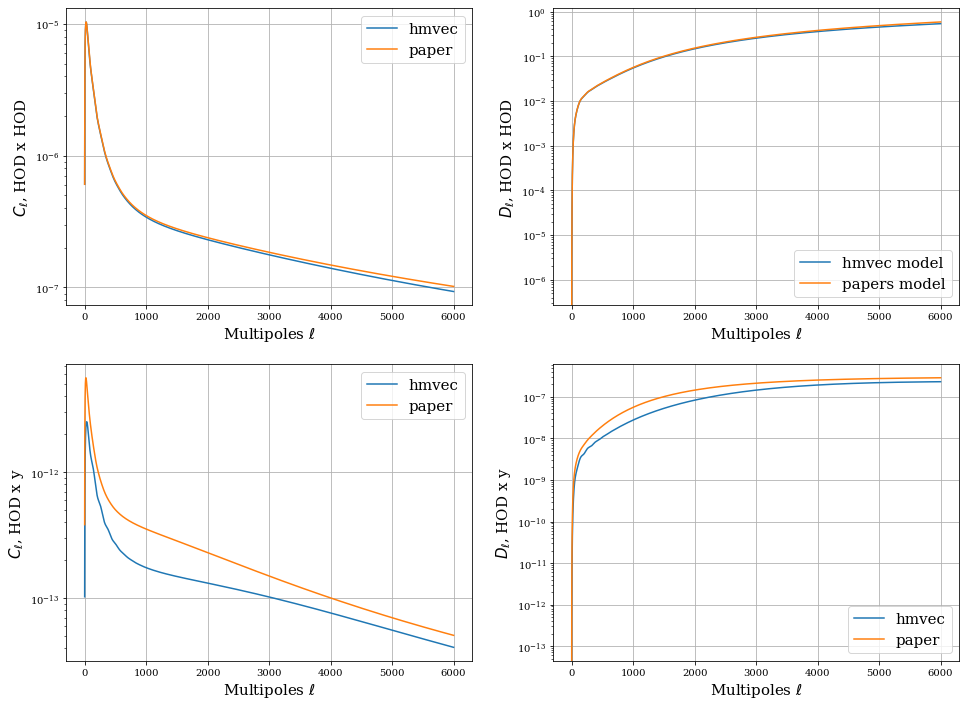

In [46]:
fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(16, 12))
plt.rc('font', family='serif')


ax1.set_xlabel('Multipoles $\\ell$', fontsize=15)
ax1.set_ylabel('$C_{\\ell}$, HOD x HOD', fontsize=15)
ax1.set_yscale('log')
ax1.grid(True)

ax1.plot(ells, gg_Cls, label='hmvec')
ax1.plot(ells, g2g2_Cls, label='paper')
ax1.legend(fontsize=15)


ax2.set_xlabel('Multipoles $\\ell$', fontsize=15)
ax2.set_ylabel('$D_{\\ell}$, HOD x HOD', fontsize=15)
ax2.set_yscale('log')
ax2.grid(True)

ax2.plot(ells, gg_Cls*ells*(ells+1)/2/np.pi, label='hmvec model')
ax2.plot(ells, g2g2_Cls*ells*(ells+1)/2/np.pi, label='papers model')
ax2.legend(fontsize=15) 

      
ax3.set_xlabel('Multipoles $\\ell$', fontsize=15)
ax3.set_ylabel('$C_{\\ell}$, HOD x y', fontsize=15)
ax3.set_yscale('log')
ax3.grid(True)

ax3.plot(ells, gy_Cls, label='hmvec')
ax3.plot(ells, g2y_Cls, label='paper')
ax3.legend(fontsize=15)


ax4.set_xlabel('Multipoles $\\ell$', fontsize=15)
ax4.set_ylabel('$D_{\\ell}$, HOD x y', fontsize=15)
ax4.set_yscale('log')
ax4.grid(True)

ax4.plot(ells, gy_Cls*ells*(ells+1)/2/np.pi, label='hmvec')
ax4.plot(ells, g2y_Cls*ells*(ells+1)/2/np.pi, label='paper')
ax4.legend(fontsize=15)

plt.show()

In [36]:
ls = np.load(path+'/Results/ls.npy')
yy_cls = np.load(path+'/Results/yy_'+galaxytype+'.npy')
gg_cls = np.load(path+'/Results/gg_'+galaxytype+'.npy')
gy_cls = np.load(path+'/Results/gy_'+galaxytype+'.npy')

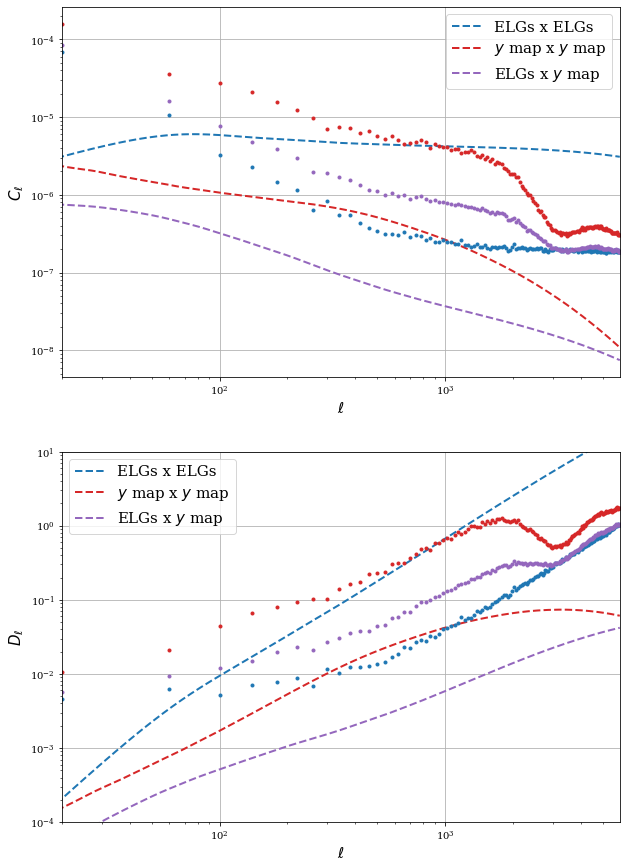

In [37]:
labelyy = "$y$ map x $y$ map"
labelgg = galaxytype +"s x "+galaxytype+"s"
labelgy = galaxytype+"s"+" x $y$ map"

# Now plot the quick powerspectrum we just made
fig, (ax1, ax2) = plt.subplots(2, 1, figsize = (10,15))


plt.rc('font', family='serif')


ax1.plot(ells, g2g2_Cls, color='tab:blue', label = labelgg, lw=2, ls='--')
ax1.plot(ells, yy_Cls/(2.75e-6)/(2.75e-6), color='tab:red', label = labelyy, lw=2, ls='--')
ax1.plot(ells, g2y_Cls/(2.75e-6), color='tab:purple', label = labelgy, lw=2, ls='--')

ax2.plot(ells, g2g2_Cls*ells*(ells+1)/2/np.pi, color='tab:blue', label = labelgg, lw=2, ls='--')
ax2.plot(ells, yy_Cls*ells*(ells+1)/2/np.pi/(2.75e-6)/(2.75e-6), color='tab:red', label = labelyy, lw=2, ls='--')
ax2.plot(ells, g2y_Cls*ells*(ells+1)/2/np.pi/(2.75e-6), color='tab:purple', label = labelgy, lw=2, ls='--')


ax1.plot(ls, gg_cls/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:blue')
ax1.plot(ls, yy_cls/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:red')
ax1.plot(ls, gy_cls/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:purple')

ax2.plot(ls, gg_cls*ls*(ls+1)/2/np.pi/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:blue')
ax2.plot(ls, yy_cls*ls*(ls+1)/2/np.pi/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:red')
ax2.plot(ls, gy_cls*ls*(ls+1)/2/np.pi/(2.75e-6)/(2.75e-6), marker=".", ls="none", color='tab:purple')

ax1.set_yscale('log')
ax1.set_xlabel('$\\ell$', fontsize = 15)
ax1.set_ylabel('$C_{\\ell}$', fontsize = 15)
ax1.grid(True)
ax1.legend(fontsize = 15)
ax1.set_xscale('log')
ax1.set_xlim(ls[0], ls[-1])

ax2.set_yscale('log')
ax2.set_xlabel('$\\ell$', fontsize = 15)
ax2.set_ylabel('$D_{\\ell}$', fontsize = 15)
ax2.grid(True)
ax2.legend(fontsize = 15)
ax2.set_xscale('log')
ax2.set_xlim(ls[0], ls[-1])
ax2.set_ylim(10e-5, 10)

plt.show()